In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate
from keras.models import Model
from keras.optimizers import Adagrad
from keras.constraints import min_max_norm

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval_hash

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath= 'outputs/05_combination_samEval2018/'

In [4]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

In [5]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

In [6]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [7]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


# Data

In [8]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval_hash()

In [9]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [10]:
train_pos =get_pos('output_trainTestData/SamEval_train_pos_hash.csv')
test_pos = get_pos('output_trainTestData/SamEval_test_pos_hash.csv')

In [11]:
train_senti_blob =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_blob_hash.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_blob_hash.csv')

# The model

In [12]:
#First part
wv_layer_minmax = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_minmax = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_minmax = wv_layer_minmax(comment_input_minmax)
x_first_minmax = Dense(600, activation='relu', kernel_constraint=min_max_norm())(embedded_sequences_minmax)
x_first_minmax = Flatten()(x_first_minmax)

#Second part
senti_input_minmax_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second_minmax = Dense(600, activation='relu', kernel_constraint=min_max_norm())(senti_input_minmax_blob)

#Thrid part
senti_input_minmax_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third_minmax = Dense(600, activation='relu', kernel_constraint=min_max_norm())(senti_input_minmax_pos)

#Concatination
concat_minmax = concatenate([x_first_minmax, x_second_minmax, x_third_minmax])

preds_minmax = Dense(2, activation='softmax')(concat_minmax)

model_minmax = Model(inputs=[comment_input_minmax, senti_input_minmax_blob, senti_input_minmax_pos], outputs=preds_minmax)
model_minmax.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      4458000     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40, 600)      180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (I

Instructions for updating:
Use tf.cast instead.


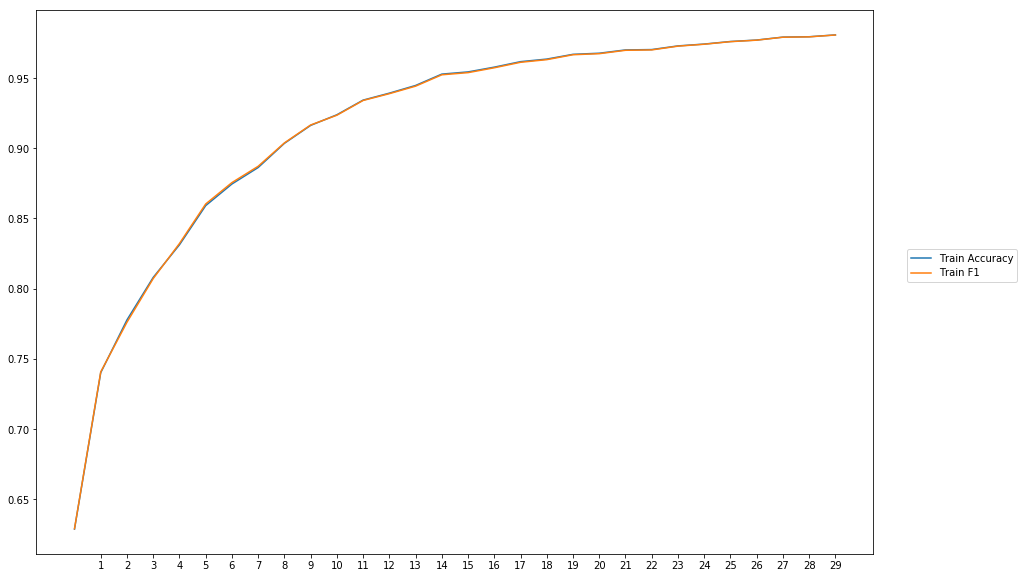


-----Test Scores----
Loss: 0.35185003949671373
Accuracy: 85.71428571428571
Precision: 78.51002863079943
Recall: 88.10289386234633
F1: 83.03029802171747


In [13]:
train_evaluate_three_inputs(model_minmax, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'SCombineExtendConstraint')